In [5]:
from itertools import product
from typing import Dict, List, Any, Tuple
import os
import pickle
from timeit import default_timer as timer

import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import Voronoi, voronoi_plot_2d, ConvexHull
from scipy.spatial import distance

from IOData.IOData import InputRule
from IOData.IODataWith_l import IODataWith_l

from simulators.track_simulator import TrackSimulator
from simulators.simulation_settings import SafetyFilterTypes, TrackFilterTypes, SimulationInputRule, ModelType
from tools.simualtion_results import Results

from tools.simple_track_generator import trackGenerator    

In [6]:
def get_datasets_hankel_matrix(io_data_list: List[IODataWith_l], lag: int, L: int) -> Tuple[np.matrix, np.matrix]:
    """Return tuple of [U_p; U_f; \tilde{Y}_p] and [\tilde{Y}_f]"""
    p = io_data_list[0]._output_data[0].shape[0]
    m = io_data_list[0]._input_data[0].shape[0]
    H_uy_noised: np.matrix = np.matrix(np.zeros(( p*lag+m*(L+lag),0 )))
    H_future_noised: np.matrix = np.matrix(np.zeros(( p*L,0 )))
    for io_data in io_data_list:
        if io_data.length >= L+lag: # only use data with enough length
            io_data.update_depth(L+lag)
            H_uy_noised_single = np.vstack( (io_data.H_input, io_data.H_output_noised_part((0, lag)),) )
            H_uy_noised = np.hstack(( H_uy_noised, H_uy_noised_single ))
            H_future_noised = np.hstack(( H_future_noised, io_data.H_output_noised_part((lag, lag+L)) ))
    return H_uy_noised, H_future_noised

In [7]:
with open(os.path.join(os.getcwd(), 'datasets', 'io_data_prbs_random_2.0_0.01_160_240.pkl'), 'rb') as read_file:
    io_data_list_1: List[IODataWith_l] = pickle.load(read_file)
with open(os.path.join(os.getcwd(), 'datasets', 'io_data_prbs_random_2.0_0.01_400.pkl'), 'rb') as read_file:
    io_data_list_2: List[IODataWith_l] = pickle.load(read_file)
with open(os.path.join(os.getcwd(), 'datasets', 'io_data_random_2.0_0.01_160_240.pkl'), 'rb') as read_file:
    io_data_list_3: List[IODataWith_l] = pickle.load(read_file)
with open(os.path.join(os.getcwd(), 'datasets', 'io_data_random_2.0_0.01_400.pkl'), 'rb') as read_file:
    io_data_list_4: List[IODataWith_l] = pickle.load(read_file)
io_data_list_list = [io_data_list_1, io_data_list_2, io_data_list_3, io_data_list_4]

In [8]:
# H_uy_list = []
# H_future_list = []
hull_list = []
# vor_list = []
volume_list = []
# dist_list = []
radius_list = []
for io_data_list in io_data_list_list:
    start = timer()
    H_uy, H_future = get_datasets_hankel_matrix(io_data_list, 1, 1)
    # H_uy_list.append(H_uy)
    # H_future_list.append(H_future)
    
    H_uy = np.array(H_uy.T)
    hull = ConvexHull(H_uy)
    hull_list.append(hull)

    vor = Voronoi(H_uy)
    # vor_list.append(vor)

    volume_list.append(hull.volume)

    dist = distance.cdist(H_uy, vor.vertices, 'euclidean')
    # dist_list.append(dist)
    radius = np.max(np.min(dist, axis=0))
    radius_list.append(radius)

    end = timer()
    print(end - start)

141.7284098750024
115.46176195799853
264.0342533340008
182.22244120800315


In [15]:
H_uy, H_future = get_datasets_hankel_matrix(io_data_list_1[1:], 1, 1)
# H_uy_list.append(H_uy)
# H_future_list.append(H_future)

H_uy = np.array(H_uy.T)
hull = ConvexHull(H_uy)
hull_list.append(hull)

vor = Voronoi(H_uy)
# vor_list.append(vor)

volume_list.append(hull.volume)

dist = distance.cdist(H_uy, vor.vertices, 'euclidean')
# dist_list.append(dist)
radius = np.max(np.min(dist, axis=0))
radius_list.append(radius)

end = timer()
print(end - start)

3338.955928083


In [16]:
print(volume_list)
print(radius_list)

[0.000991419761346052, 3.7756883321690763e-07, 0.002427078097183792, 5.7204412223177866e-06, 0.0009461183605997144]
[3500922468.0990086, 4310981.093002612, 29008187514.209797, 69026632.72967894, 3500922468.0907087]


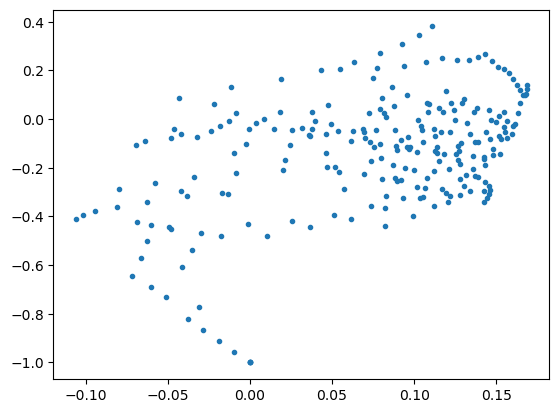

In [21]:
plt.scatter(H_uy[:,-2], H_uy[:,-1], marker='.')
x_label = r'v_x - v_0'
y_label = r'v_y'

In [ ]:
example_points = 

In [14]:
d = H_uy.shape[1]
np.power(volume_list[1]/volume_list[0], 1/d)


0.373759569467762